## 1. Import needed packages

In [1]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Import pyplot from matplotlib
import matplotlib.pyplot as plt

# Import TensorFlow & Keras 
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as tf_backend 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, ModelCheckpoint
from sklearn.decomposition import PCA

# Import all other needed packages
import scipy.stats as stats
import numpy as np
import math
import csv
from PIL import Image
import random
import os
import json

%matplotlib inline

## 2. Load all vectors

In [2]:
# Forming feature vectors dictionary
feature_vectors_dictionary = {}

with open('./output/keras_facenet_feature_vectors.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for i, row in enumerate(reader):
        if i == 0:
            continue
        
        person_id = int(float(row[0]))
        feature_vector = np.array(row[2:])
        feature_vector = feature_vector.astype(np.float)
        
        if person_id not in feature_vectors_dictionary:
            feature_vectors_dictionary[person_id] = [feature_vector]
            continue
            
        feature_vectors_dictionary[person_id].append(feature_vector)

dictionary_values = list(feature_vectors_dictionary.values()) 
        
# Finding minimal array size
min_array_length = int(1e10)
for value in dictionary_values:
    min_array_length = min(min_array_length, len(value))

# Forming tensorflow and numpy arrays
feature_vector_batches_np = []
feature_vector_batches_tf = []
labels = []

for key in feature_vectors_dictionary:
    value = feature_vectors_dictionary[key]
    value_np = np.array(value[:min_array_length])
    labels.extend([key] * min_array_length)
    feature_vector_batches_np.extend(value_np)
    feature_vector_batches_tf.extend(tf.convert_to_tensor(value_np))

2023-01-26 01:36:59.560814: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 01:36:59.562348: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
# Shuffle two lists
temp = list(zip(feature_vector_batches_np, feature_vector_batches_tf, labels))
random.shuffle(temp)
temp_batches_np, temp_batches_tf, temp_labels = zip(*temp)
feature_vector_batches_np, feature_vector_batches_tf, labels = list(temp_batches_np), list(temp_batches_tf), list(temp_labels)

feature_vector_batches_tf = tf.stack(feature_vector_batches_tf)

In [4]:
def binary_distance(s1, s2):
    return tf.reduce_mean(tf.abs(s1-s2),axis=0)

# Check binary distance formula
s1 = tf.constant([0.0, 0.0, 1.0, 1.0])
s2 = tf.constant([0.0, 0.0, 1.0, 0.0])
print(binary_distance(s1, s2))

def convert_to_binary_string(f):
    return tf.where(tf.less(f, 0.0), 0.0, 1.0)

f = tf.constant([1.3, 2.5, -2.3, 0.2, -0.3])
print(convert_to_binary_string(f))

def binary_distance_vectors(f1, f2):
    return binary_distance(convert_to_binary_string(f1), convert_to_binary_string(f2))

f1 = tf.constant([-0.2, -0.3, 0.4, 0.5])
f2 = tf.constant([-0.6, -0.7, 0.8, -0.9])
print(binary_distance_vectors(f1, f2))

tf.Tensor(0.25, shape=(), dtype=float32)
tf.Tensor([1. 1. 0. 1. 0.], shape=(5,), dtype=float32)
tf.Tensor(0.25, shape=(), dtype=float32)


Text(0.5, 0, 'Sigma score')

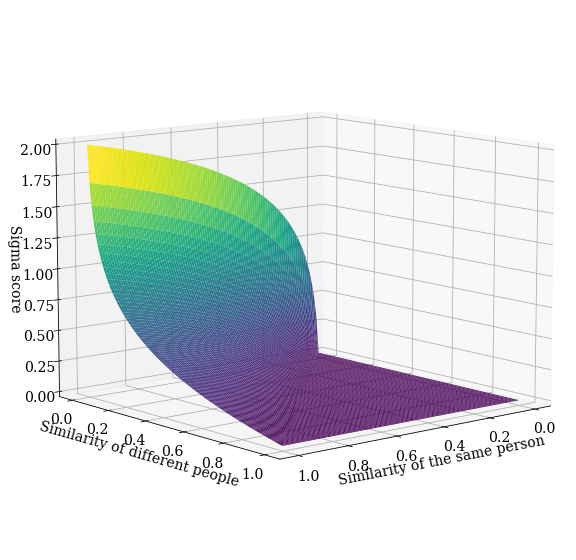

In [96]:
def accuracy(x, y):
    return np.maximum(np.log10(x/(y+0.01)), 0)

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)

X, Y = np.meshgrid(x, y)
Z = accuracy(X, Y)

plt.rcParams['text.usetex'] = False
plt.figure(figsize=(8,10))
ax = plt.axes(projection='3d')
ax.view_init(10, 50)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Similarity of the same person')
ax.set_ylabel('Similarity of different people')
ax.set_zlabel('Sigma score')

# Suppose 
$$
\mathbf{x},\mathbf{y} \sim p 
$$

Suppose we have $\mathcal{P}_{\text{same}}$ and $\mathcal{P}_{\text{diff}}$. We need to maximize
$$
\mathcal{L}(\mathcal{P}\mid\psi,\beta) = \frac{\beta}{|\mathcal{P}_{\text{same}|}}\sum_{\mathbf{x},\mathbf{y} \in \mathcal{P}_{\text{same}}}(1-\delta(\psi(\mathbf{x}),\psi(\mathbf{y}))) + \frac{1-\beta}{|\mathcal{P}_{\text{diff}}|}\sum_{\mathbf{x},\mathbf{y} \in \mathcal{P}_{\text{diff}}}\delta(\psi(\mathbf{x}),\psi(\mathbf{y}))
$$

Thus
$$
\hat{\psi} = \arg\max_{\psi} \mathcal{L}(\mathcal{P},\psi)
$$

Expected value of loss function:
$$
\mathbb{E}[\mathcal{L}(\mathcal{P})]=
$$

### Expected value $\mathbb{E}[X]$
Suppose we have $\{\mathbf{x}_k\}_{k=1}^N$. Then the expected value:
$$
\mathbb{E}(X) \equiv \mu = \frac{1}{N} \sum_{k=1}^N \mathbf{x}_k
$$

In [12]:
from pingouin import multivariate_normality

print(feature_vector_batches_np[0])
print(multivariate_normality(feature_vector_batches_np))

[ 0.78466594 -0.80360818 -0.42163581 -0.52353412 -0.88326854  0.13784534
 -0.62944192  1.48301387 -0.74948835  0.61092436 -1.12175953 -0.59363699
  2.01930356  2.09309459 -0.50906348 -0.18032877  0.28957266 -2.10113955
  1.68625462  0.21627055 -1.71811128  2.04097366 -1.36740696  1.55526102
 -0.38748041 -0.42562088  0.69820297 -0.77505374  0.55290651 -1.261742
  1.83694613 -0.41175669  2.62878418 -0.88265258 -0.20031996  0.26345757
  1.0144794   1.07842577  1.18951368  2.47711015  0.92784941  0.75745213
  1.55546308 -0.64702165  0.027276    0.43004236 -1.75684881  1.07162237
  0.85259038 -1.02106595 -0.93338746  1.57940149 -1.11782432 -0.16260689
 -1.45488238  1.65794289  0.54148811 -0.28157818 -2.28611898 -0.52840126
  0.26398596  1.24746788 -2.76092935  1.05165946 -1.16902423  0.03340774
  1.56586015 -0.12257067 -0.71972454 -0.38035166  1.11265802  1.74732518
  1.09267056  0.19795467  0.45586127 -1.02670979  0.15503001 -1.07378125
 -0.6351493   0.60942525  0.14413571  0.79333103  1.6

In [126]:
component_id = 13

thresholds = [int(x*100)/100 for x in np.linspace(-4,4,50)]
segments, bar_labels = [], []

for i in range(len(thresholds)-1):
    segments.append([thresholds[i], thresholds[i+1]])
    bar_labels.append(str(thresholds[i]) + '...' + str(thresholds[i+1]))
    
values = np.zeros(len(segments))
    
def is_in_segment(value, segment):
    return value <= segment[1] and value >= segment[0]

for vector in feature_vector_batches_tf:
    for i, segment in enumerate(segments):
        if is_in_segment(vector[component_id], segment):
            values[i] += 1.0
            break

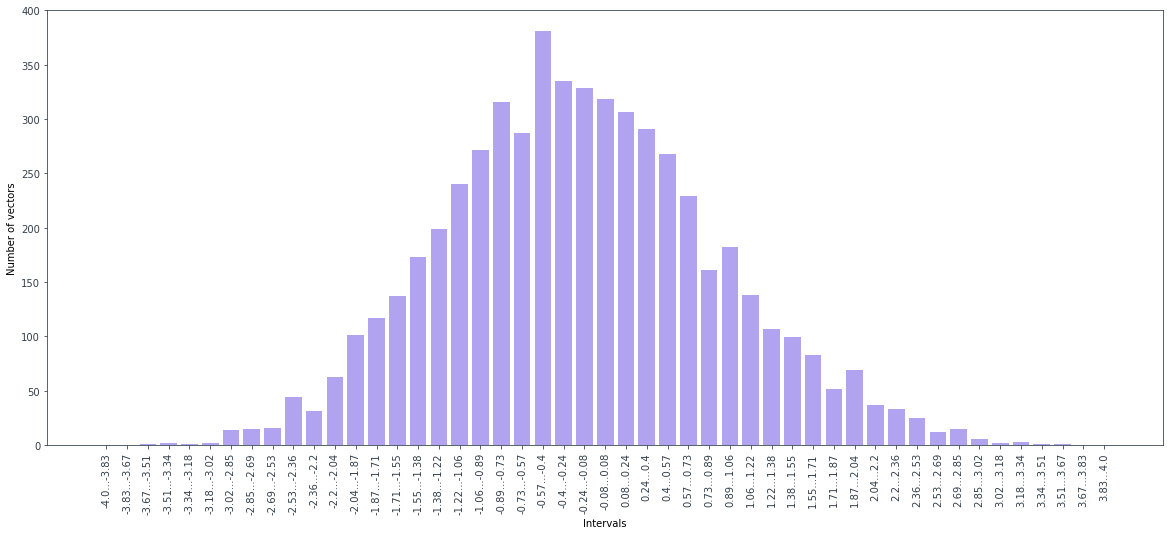

In [128]:
plt.figure(figsize=(20, 8))

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

plt.xlabel("Intervals")
plt.ylabel("Number of vectors")

plt.bar(range(len(bar_labels)), values, color=(0.5,0.4,0.9,0.6))
plt.xticks(range(len(bar_labels)), bar_labels, rotation='vertical')

plt.show()

### Applying PCA

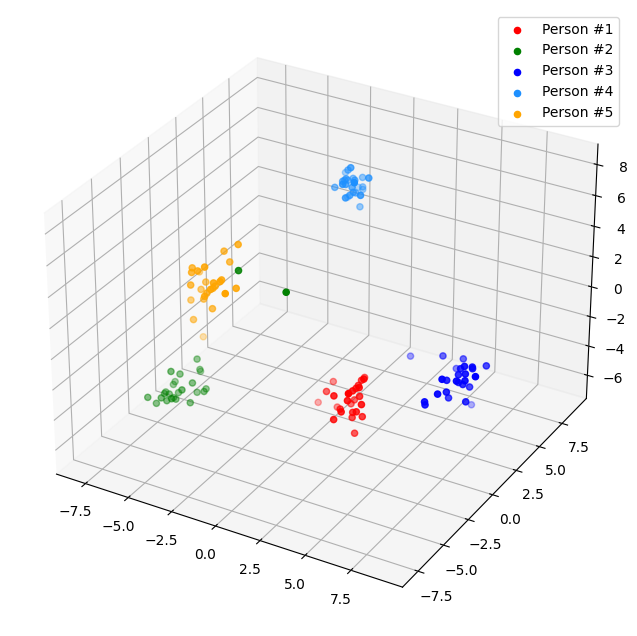

In [51]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

pca = PCA(n_components=3)

batch_1 = [vector for k, vector in enumerate(feature_vector_batches_tf) if labels[k] == 10]
color_1 = [1] * len(batch_1)
batch_2 = [vector for k, vector in enumerate(feature_vector_batches_tf) if labels[k] == 20]
color_2 = [2] * len(batch_2)
batch_3 = [vector for k, vector in enumerate(feature_vector_batches_tf) if labels[k] == 50]
color_3 = [3] * len(batch_3)
batch_4 = [vector for k, vector in enumerate(feature_vector_batches_tf) if labels[k] == 21]
color_4 = [4] * len(batch_4)
batch_5 = [vector for k, vector in enumerate(feature_vector_batches_tf) if labels[k] == 90]
color_5 = [5] * len(batch_5)

batches = [*batch_1, *batch_2, *batch_3, *batch_4, *batch_5]
colors = [*color_1, *color_2, *color_3, *color_4, *color_5]

batch_scaled = preprocessing.StandardScaler().fit_transform(batches)
pca_features = pca.fit_transform(batch_scaled)

plt.style.use('default')

# Plot scaled features
xdata = pca_features[:,0]
ydata = pca_features[:,1]
zdata = pca_features[:,2]
 
# Plot 3D plot
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

n1 = len(batch_1)
n2 = len(batch_1) + len(batch_2)
n3 = len(batch_1) + len(batch_2) + len(batch_3)
n4 = len(batch_1) + len(batch_2) + len(batch_3) + len(batch_4)
n5 = len(batch_1) + len(batch_2) + len(batch_3) + len(batch_4) + len(batch_5)

ax.scatter3D(xdata[:n1], ydata[:n1], zdata[:n1], c='r', label='Person #1', cmap='jet')
ax.scatter3D(xdata[n1:n2], ydata[n1:n2], zdata[n1:n2], c='g', label='Person #2', cmap='jet')
ax.scatter3D(xdata[n2:n3], ydata[n2:n3], zdata[n2:n3], c='b', label='Person #3', cmap='jet')
ax.scatter3D(xdata[n3:n4], ydata[n3:n4], zdata[n3:n4], c='dodgerblue', label='Person #4', cmap='jet')
ax.scatter3D(xdata[n4:n5], ydata[n4:n5], zdata[n4:n5], c='orange', label='Person #5', cmap='jet')

ax.legend()
#ax.scatter3D(xdata, ydata, zdata, c=colors, cmap='jet')
 
# Plot title of graph

plt.show()